# Gaussian surface approximation code
When an appropriate image is selected, this code is then used to fit a Gaussian surface

In [2]:
# Import packages
import os
import re  # regular expressions for getting lat lon grid
import pathlib
import warnings
import gdal
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio as rio # for extracting subsets
from rasterio.plot import plotting_extent #for plotting
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em
import pandas as pd
import pickle

#for the reprojecting
import pyproj
from pyproj import CRS
import cartopy
import cartopy.crs as ccrs
from shapely.geometry import Point, LineString, Polygon
from pyhdf.SD import SD, SDC
import datetime as dt
import scipy
from scipy import interpolate
import geopandas as gpd

#for reading LULC data (netcdf)
import xarray as xr

#for finding the nearest points (to merge LULC data)
import heapq
import operator

#Regression packages (used for linear and polynomial regression)
import operator
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

#for root finding and curve fitting
from scipy import optimize
from scipy.optimize import curve_fit

#for converting angles from radians to degrees
import math

warnings.simplefilter('ignore')

#Define functions for bit flag interpretation
#bit flag interpretation
#Defining QC functions
#function to check the status of a byte on the QC control
def check_bits(x,n):
    if (x & (1<<n)): 
  ## n-th bit is 1 
        flag = 1
    else:
  ## n-th bit is 0
        flag = 0
    return flag

#function to check bytes 1 and 2 and return 0 if they are both 0
def quality_control(x):
    if ((check_bits(x,1) == 0) and (check_bits(x,2) == 0)):
  ##if bit 1 and bit 2 are 0 then 0 
        flag = 0
    else:
  ##otherwise flag is 1
        flag = 1
    return flag    

In [3]:
#Manual entries
CITY_COUNTRY = "LINQING_CHINA"
City_Lat = 36.84556
City_Lon = 115.71167

#SATELLITE = 'MOD11A2' #TERRA
SATELLITE = 'MYD11A2' #AQUA

#set the fraction of pixels which make the image unusable (if there is a greater number of pixels then this of bad quality, 
#image will not be used)
unusable_cutoff = 0.3

#Specify the LCLU file to be used
LULC_filepath = '../../../ESA_CCI_Landcover/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7b.nc'

In [4]:
# Set working directory
#MOD11A2 is terra
#MYD11A2 is aqua

#Set path to chosen satellite

os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))
#set path to current directory
path = pathlib.Path().absolute()
            
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.2
max_lat = City_Lat + 0.2
min_lon = City_Lon - 0.2
max_lon = City_Lon + 0.2

#Read pickle files back in from image select code. Images to be used can be selected from this
with open('Day_list.pkl', 'rb') as f:
    Day_list = pickle.load(f)
    
with open('Night_list.pkl', 'rb') as f:
    Night_list = pickle.load(f)

In [5]:
#show day list
Day_list

['MYD11A2.A2002185.h27v05.006.2015146152711.hdf',
 'MYD11A2.A2002193.h27v05.006.2015146153051.hdf',
 'MYD11A2.A2002233.h27v05.006.2015149173024.hdf',
 'MYD11A2.A2002241.h27v05.006.2015150015142.hdf',
 'MYD11A2.A2002249.h27v05.006.2015150080035.hdf',
 'MYD11A2.A2002257.h27v05.006.2015152225441.hdf',
 'MYD11A2.A2002265.h27v05.006.2015160195835.hdf',
 'MYD11A2.A2002273.h27v05.006.2015161034539.hdf',
 'MYD11A2.A2002281.h27v05.006.2015161122742.hdf',
 'MYD11A2.A2002289.h27v05.006.2015161232548.hdf',
 'MYD11A2.A2002305.h27v05.006.2015162205414.hdf',
 'MYD11A2.A2002329.h27v05.006.2015164043037.hdf',
 'MYD11A2.A2003009.h27v05.006.2015181163714.hdf',
 'MYD11A2.A2003025.h27v05.006.2015182091247.hdf',
 'MYD11A2.A2003033.h27v05.006.2015182143858.hdf',
 'MYD11A2.A2003081.h27v05.006.2015188011702.hdf',
 'MYD11A2.A2003097.h27v05.006.2015194151233.hdf',
 'MYD11A2.A2003105.h27v05.006.2015194180048.hdf',
 'MYD11A2.A2003113.h27v05.006.2015195004627.hdf',
 'MYD11A2.A2003121.h27v05.006.2015195064429.hdf',


In [21]:
file_name = 'MYD11A2.A2003033.h27v05.006.2015182143858.hdf'
yeardoy = file_name.split('.')[1][1:]                               # Split filename to retrieve acquisition date
date = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%d/%m/%Y') 
date

'02/02/2003'

In [22]:
#file to be used 
#picked at random for now - 4th July 2018
file_name = 'MYD11A2.A2003033.h27v05.006.2015182143858.hdf'

#path to the file
data_path = os.path.join(file_name)

In [23]:
#Extract the subdatasets of interest
#QC is still needed as the pixels which are of bad quality will still need to be removed/ masked 

#LST daytime
with rio.open(data_path) as dataset:
    # Loop through each subdataset in HDF4 file
    for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has LST:LST in the name
        if re.search("LST:LST_Day_1km*", name):
        
            # Open the band subdataset
            with rio.open(name) as subdataset:
                modis_meta = subdataset.profile
                
                # Read band data as a 2 dim arr and append to list
                LST_day = subdataset.read(1)
                
#LST night       
with rio.open(data_path) as dataset:
    # Loop through each subdataset in HDF4 file
    for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has LST:LST in the name
        if re.search("LST:LST_Night_1km*", name):
        
            # Open the band subdataset
            with rio.open(name) as subdataset:
                modis_meta = subdataset.profile
                
                # Read band data as a 2 dim arr and append to list
                LST_night = subdataset.read(1)                
                
                
#QC day      
with rio.open(data_path) as dataset:
    # Loop through each subdataset in HDF4 file
    for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has LST:LST in the name
        if re.search("LST:QC_Day*", name):
        
            # Open the band subdataset
            with rio.open(name) as subdataset:
                modis_meta = subdataset.profile
                
                # Read band data as a 2 dim arr and append to list
                QC_day = subdataset.read(1)   
                
#QC night       
with rio.open(data_path) as dataset:
    # Loop through each subdataset in HDF4 file
    for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has LST:LST in the name
        if re.search("LST:QC_Night*", name):
        
            # Open the band subdataset
            with rio.open(name) as subdataset:
                modis_meta = subdataset.profile
                
                # Read band data as a 2 dim arr and append to list
                QC_night = subdataset.read(1)   
                
                
#Create the coordinate grid
# Identify the data field- use the LST day but grid is same for all data
DATAFIELD_NAME = 'LST_Day_1km'

GRID_NAME = 'MODIS_Grid_8Day_1km_LST'

hdf = SD(file_name, SDC.READ)

# Read dataset.
data2D = hdf.select(DATAFIELD_NAME)
data = data2D[:,:].astype(np.float64)

# Read global attribute.
fattrs = hdf.attributes(full=1)
ga = fattrs["StructMetadata.0"]
gridmeta = ga[0]

# Construct the grid.  Required information in global attribute called 'StructMetadata.0'

ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
                                  (?P<upper_left_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<upper_left_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
match = ul_regex.search(gridmeta)
x0 = np.float(match.group('upper_left_x')) 
y0 = np.float(match.group('upper_left_y')) 

lr_regex = re.compile(r'''LowerRightMtrs=\(
                                  (?P<lower_right_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<lower_right_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
match = lr_regex.search(gridmeta)
x1 = np.float(match.group('lower_right_x')) 
y1 = np.float(match.group('lower_right_y')) 
ny, nx = data.shape
xinc = (x1 - x0) / nx
yinc = (y1 - y0) / ny

x = np.linspace(x0, x0 + xinc*nx, nx)
y = np.linspace(y0, y0 + yinc*ny, ny)
xv, yv = np.meshgrid(x, y)

# convert the grid back to lat/lons.
sinu = pyproj.Proj("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext")
wgs84 = pyproj.Proj("+init=EPSG:4326") 
lon, lat= pyproj.transform(sinu, wgs84, xv, yv)

#Apply scale factors
scale_factor_LST = 0.02

LST_day = LST_day*scale_factor_LST
LST_night = LST_night*scale_factor_LST

#Note: fill value for LST is 0


In [24]:
#Create the lists to be combined to create a dataframe
LST_day_list = LST_day.flatten()
LST_night_list = LST_night.flatten()
QC_day_list = QC_day.flatten()
QC_night_list = QC_night.flatten()
Lon_list = lon.flatten()
Lat_list = lat.flatten()

#Create the dataframe

df = pd.DataFrame(list(zip(LST_day_list, LST_night_list, QC_day_list, QC_night_list, Lon_list, Lat_list)), 
               columns =['LST_day', 'LST_night','QC_day', 'QC_night','Longitude', 'Latitude']) 

#Create dataframe of the required area
df_subset = df[(df.Latitude >min_lat) & (df.Latitude < max_lat) & (df.Longitude > min_lon) & (df.Longitude < max_lon)]

Observation point, don't need to run the below code

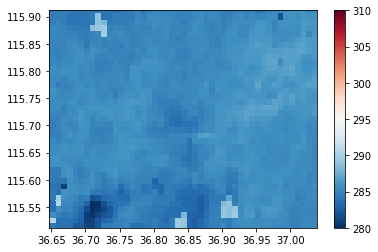

In [25]:
########################OBSERVATION POINT ################################################
#Check points by plotting
#specify x,y,LSTs
x= df_subset.Latitude
y= df_subset.Longitude
LST = df_subset.LST_day

#get the points into the correct format
X,Y = np.meshgrid(x,y)
Z = scipy.interpolate.griddata((x, y), LST, (X,Y), method='nearest')

#Make plot
#Colour mesh plot
plt.pcolormesh(X,Y,Z, cmap ='RdBu_r', vmin = 280, vmax = 310)
plt.colorbar()

In [26]:
#Change the coordinate reference system
#lat and lon coordinates are not accurate as they are distorted by the shape of the map

#function for finding the UTM projection
def utm_zoner(lon, lat):
    utm_lon = lon+180
    utm_zone = int(np.ceil(utm_lon/6))
    south_hem =''
    if lat<0:
        south_hem = ' +south'
    proj_str = f'+proj=utm +zone={utm_zone}{south_hem}'
    return proj_str

#Get the UTM of the city
local_utm = CRS.from_proj4(utm_zoner(City_Lon, City_Lat))

#get geometry of the subset
df_subset_geometry = [Point(xy) for xy in zip(df_subset.Longitude, df_subset.Latitude)]

#transform into a geopandas dataframe
gdf = gpd.GeoDataFrame(df_subset, geometry=df_subset_geometry)
gdf.crs= {'init': 'epsg:4326', 'no_defs': True}

gdf2 = gdf.to_crs(epsg=local_utm.to_epsg()).copy() #create a new geo dataframe, with units in m, cartesian 2D axis 

#origin coordinates - take to be city centre
#create a data frame with origin points
origin_df = pd.DataFrame(
    {'City': [CITY_COUNTRY],
     'Latitude': [City_Lat],
     'Longitude': [City_Lon]})

origin_df_geometry = [Point(xy) for xy in zip(origin_df.Longitude, origin_df.Latitude)]

origin_gdf = gpd.GeoDataFrame(origin_df, geometry=origin_df_geometry)

origin_gdf.crs= {'init': 'epsg:4326', 'no_defs': True}
origin_gdf = origin_gdf.to_crs(epsg=local_utm.to_epsg())

#Now change the grid so the the origin is the city centre 

#Extract the x and y coordinates 
x_points = gdf2['geometry'].x
y_points = gdf2['geometry'].y

#and add the extracted coordinates to dataframe
gdf2['xpoints'] = x_points
gdf2['ypoints'] = y_points

#Determine the origin (city centre)
origin_x = origin_gdf['geometry'].x
origin_y = origin_gdf['geometry'].y

#Subtract the orgin from the points
gdf2['x_points'] = gdf2['xpoints'] - origin_x.values
gdf2['y_points'] = gdf2['ypoints'] - origin_y.values

#Drop the xpoints and ypoints columns as they are no longer needed
gdf2 = gdf2.drop('xpoints', axis = 1)
gdf2 = gdf2.drop('ypoints', axis = 1)


Observation point 

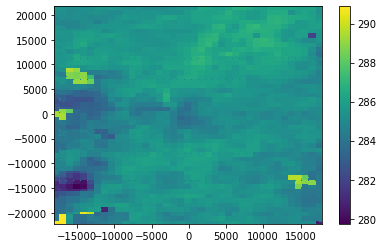

In [27]:
#################### OBSERVATION POINT #######################
#Check points by plotting
#specify x,y,LSTs
x= gdf2.x_points
y= gdf2.y_points
LST = gdf2.LST_day

#get the points into the correct format
X,Y = np.meshgrid(x,y)
Z = scipy.interpolate.griddata((x, y), LST, (X,Y), method='nearest')

#Make plot
#Colour mesh plot
plt.pcolormesh(X,Y,Z)
plt.colorbar()

In [28]:
#Take a look at the quality of the data
#This should already be so that a specified number of pixels are usable (as image selection code checks this)
#to do this we will use the QC flag. The QC flag is a bit flag, so need to extract the relevent bytes, and select the data based on these
#first of all need to write a function to extract required bytes
#Then apply the function to the QC list to check bytes 1 and 2. Then append this new list onto our data frame.
#if the first 2 bytes are 0 then the quality is good. 

#first off all define the functions

#function to check the status of a byte on the QC control
def check_bits(x,n):
    if (x & (1<<n)): 
  ## n-th bit is 1 
        flag = 1
    else:
  ## n-th bit is 0
        flag = 0
    return flag

#function to check bytes 1 and 2 and return 0 if they are both 0
def quality_control(x):
    if ((check_bits(x,1) == 0) and (check_bits(x,2) == 0)):
  ##if bit 1 and bit 2 are 0 then 0 
        flag = 0
    else:
  ##otherwise flag is 1
        flag = 1
    return flag

#Take the QC flags out the dataframe to apply the function to 
QC_day = gdf2.QC_day
QC_night = gdf2.QC_night

#Apply to function to QC
QC_day2 = np.array([quality_control(int(i)) for i in QC_day])
QC_night2 = np.array([quality_control(int(i)) for i in QC_night])


#And add this QC2 flag onto the dataset
gdf2['QC_day2'] = QC_day2
gdf2['QC_night2'] = QC_night2


Observation Point

Text(0, 0.5, 'Y distance')

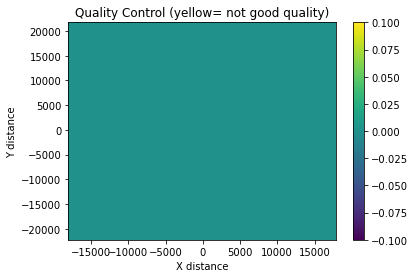

In [29]:
####  OBSERVATION POINT   #####

#Check the points which are not useable based on QC flag

#first grid the QC_2 flag
QC_2 = gdf2.QC_day2
QC_Z = scipy.interpolate.griddata((x, y), QC_2, (X,Y), method='nearest')

#Then plot 
plt.pcolormesh(X,Y,QC_Z)
plt.colorbar()
plt.title('Quality Control (yellow= not good quality)')
plt.xlabel('X distance')
plt.ylabel('Y distance')

In [30]:
#This doesn't work as computer doesn't have enough memory need to use JASMIN
#Now need to add in the land cover data in order to apply the urban mask
#Will apply the mask to the urban areas and the areas with QC2 flag = 1

#first load in LULC data
#crs wgs84
#code for urban areas: 190

LULC_ds=xr.open_dataset(LULC_filepath)

#Take the subset of required area before it can be made into a a dataframe
#select the subset 

temp_subset_LULC_ds = LULC_ds.sel(lat =(LULC_ds.lat > min_lat) & (LULC_ds.lat < max_lat), method = 'nearest')

subset_LULC_ds = temp_subset_LULC_ds.sel(lon =(temp_subset_LULC_ds.lon >min_lon) & (temp_subset_LULC_ds.lon < max_lon), method = 'nearest')

#Add lat and lon as variables so more easy to use in dataframe
subset_LULC_ds['lats'] = subset_LULC_ds['lat']
subset_LULC_ds['lons'] = subset_LULC_ds['lon']

#send to dataframe
#subset_LULC_df = subset_LULC_ds.to_dataframe()

In [31]:
#export file to csv 
gdf2.to_csv(r'GSA_Code_gdf2.csv', index = False)
#JASMIN doesn't have pyproj csv so also need this;
print('epsg',local_utm.to_epsg() )


epsg 32650


In [32]:
gdf2

,LST_day,LST_night,QC_day,QC_night,Longitude,Latitude,geometry,x_points,y_points,QC_day2,QC_night2
426265,285.26,265.70,0,0,115.519231,37.039199,POINT (368310.627 4100246.069),-16824.669827,21731.529714,0,0
426266,285.16,265.74,0,0,115.529680,37.039199,POINT (369239.906 4100231.650),-15895.390561,21717.110892,0,0
426267,285.12,265.84,0,0,115.540128,37.039199,POINT (370169.184 4100217.333),-14966.112499,21702.794236,0,0
426268,285.22,265.82,0,0,115.550577,37.039199,POINT (371098.461 4100203.119),-14036.835633,21688.579744,0,0
426269,285.58,265.84,0,0,115.561025,37.039199,POINT (372027.737 4100189.007),-13107.559953,21674.467414,0,0
...,...,...,...,...,...,...,...,...,...,...,...
482755,285.22,266.92,65,0,115.864130,36.647206,POINT (398467.800 4056337.714),13332.503560,-22176.824733,0,0
482756,285.22,266.98,65,0,115.874525,36.647206,POINT (399397.026 4056326.768),14261.729520,-22187.771450,0,0
482757,285.22,266.92,65,0,115.884920,36.647206,POINT (400326.251 4056315.922),15190.954520,-22198.617489,0,0
482758,285.06,267.04,65,0,115.895315,36.647206,POINT (401255.475 4056305.176),16120.178568,-22209.362851,0,0


In [33]:
print((min(gdf2['Latitude']), min(gdf2['Longitude'])) , (max(gdf2['Latitude']), max(gdf2['Longitude'])))

(36.64720600500491, 115.51183700887754) (37.039199332777876, 115.91155257429665)


In [ ]:
(36.64720600500491, 115.51183700887754) (37.039199332777876, 115.91155257429665)